<a href="https://colab.research.google.com/github/ErickAxelMartinezRios/Propeller-Fault-Detection-with-1D-CNN-/blob/main/1D_CNN_for_propeller_faul_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_filter.mat to data_filter.mat


In [47]:
import  scipy.io
import numpy as np
mat = scipy.io.loadmat('data_filter.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data_final', 'labels'])

In [48]:
data = mat['data_final']
data.shape

(9992, 1000)

In [72]:
labels = mat['labels']
labels.shape

(9992,)

In [73]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

y=labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes)

Counter({np.str_('F0'): 3063, np.str_('F3'): 2318, np.str_('F2'): 2309, np.str_('F1'): 2302})


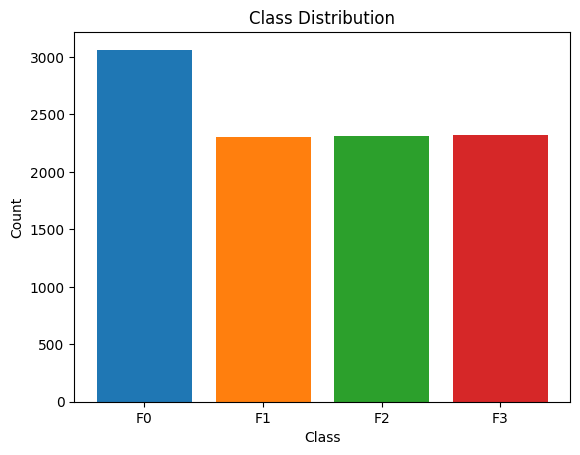

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
freq = Counter(labels)
print(freq)
cmap = plt.get_cmap('tab10')
colors = cmap.colors[:4]  # Take first N colors
labels = list(freq.keys())
values = list(freq.values())
plt.bar(labels, values, color = colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

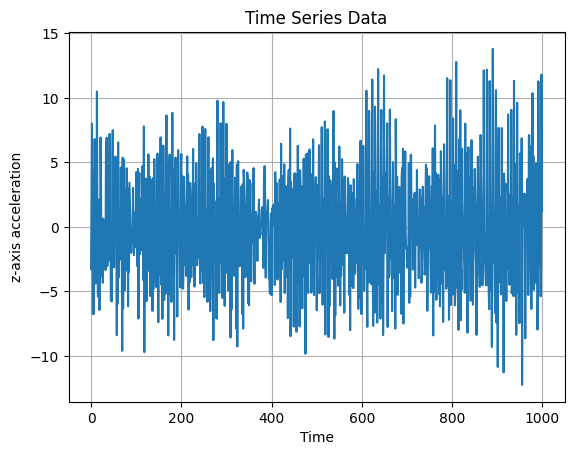

In [77]:
plt.plot(data[50])
plt.xlabel('Time')
plt.ylabel('z-axis acceleration')
plt.title('Time Series Data')
plt.grid(True)
plt.show()

In [78]:
from sklearn.model_selection import train_test_split
X = data
X_temp, X_test, y_temp, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (6394, 1000)
y_train shape: (6394, 4)
X_val shape: (1599, 1000)
y_val shape: (1599, 4)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Find minimum length for trimming or maximum length for padding
min_length = min(len(x) for x in X_train)

# Pad to the left (like MATLAB) using 'pre'
X_train_padded = pad_sequences(X_train, maxlen=min_length, dtype='float32', padding='pre')
X_val_padded = pad_sequences(X_val, maxlen=min_length, dtype='float32', padding='pre')
X_test_padded = pad_sequences(X_test, maxlen=min_length, dtype='float32', padding='pre')

# Reshape to (samples, time_steps, 1)
X_train_padded = np.expand_dims(X_train_padded, axis=-1)
X_val_padded = np.expand_dims(X_val_padded, axis=-1)
X_test_padded = np.expand_dims(X_test_padded, axis=-1)

print("X_train_padded shape:", X_train_padded.shape)
print("X_val_padded shape:", X_val_padded.shape)
print("X_test_padded shape:", X_test_padded.shape)

X_train_padded shape: (6394, 1000, 1)
X_val_padded shape: (1599, 1000, 1)
X_test_padded shape: (1999, 1000, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, ReLU, LayerNormalization, AveragePooling1D,
                                     GlobalAveragePooling1D, Dense, Input)
from tensorflow.keras import regularizers
model = Sequential([
    Input(shape=(min_length, 1)),
    Conv1D(32, 7, padding='causal',kernel_regularizer=regularizers.l2(0.001)),
    ReLU(),
    LayerNormalization(center=False, scale=False),
    AveragePooling1D(pool_size=4, strides=4),
    Conv1D(64, 5, padding='causal',kernel_regularizer=regularizers.l2(0.001)),
    ReLU(),
    AveragePooling1D(pool_size=4, strides=4),
    LayerNormalization(center=False, scale=False),
    GlobalAveragePooling1D(),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 1000, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 1000, 32)       │             0 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_4             │ (None, 250, 32)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 250, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_5             │ (None, 62, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 62, 64)         │             0 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,820 (42.27 KB)

 Trainable params: 10,820 (42.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
history = model.fit(X_train_padded, y_train, epochs=50, batch_size=128*4, validation_data=(X_val_padded, y_val))

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 869ms/step - accuracy: 0.2672 - loss: 2.3488 - val_accuracy: 0.3340 - val_loss: 1.4188
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 912ms/step - accuracy: 0.3463 - loss: 1.3968 - val_accuracy: 0.4321 - val_loss: 1.3179
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 970ms/step - accuracy: 0.4227 - loss: 1.3091 - val_accuracy: 0.4359 - val_loss: 1.2796
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 924ms/step - accuracy: 0.4471 - loss: 1.2587 - val_accuracy: 0.4503 - val_loss: 1.2485
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 896ms/step - accuracy: 0.4786 - loss: 1.2285 - val_accuracy: 0.4872 - val_loss: 1.2246
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 906ms/step - accuracy: 0.4996 - loss: 1.2105 - val_accuracy: 0.4997 - val_loss: 1.2008
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 804ms/step - accuracy: 0.5308 - loss: 1.1686 - val_accuracy: 0.5091 - val_loss: 1.1798
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 851ms/step - accuracy: 0.5221 - loss: 1.1629 - val_accu

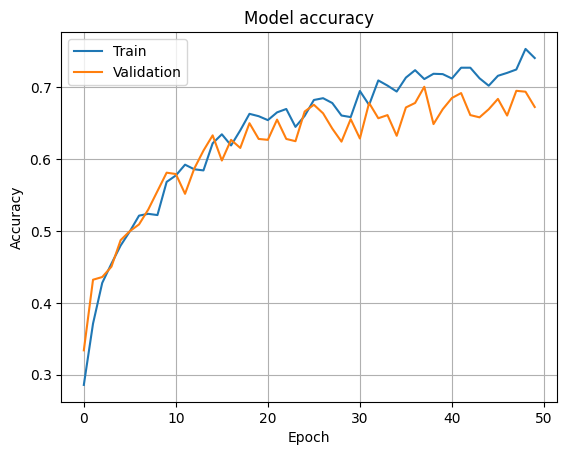

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


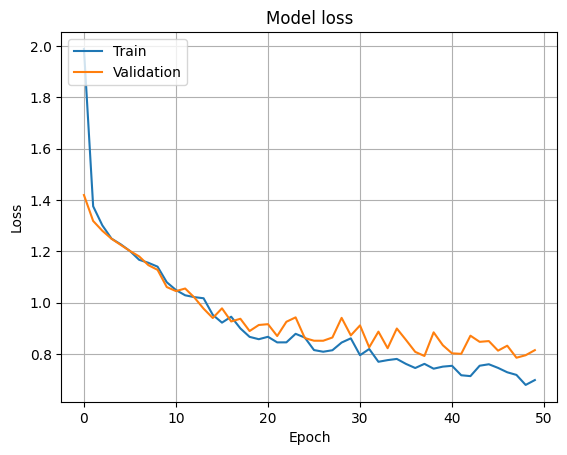

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

In [ ]:
test_loss, test_acc = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {test_acc:.2%}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6703 - loss: 0.8322
Test Accuracy: 67.73%


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


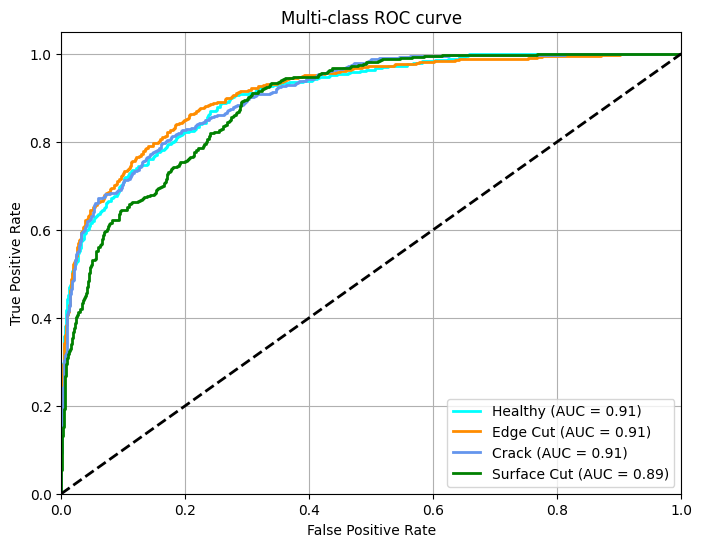

In [ ]:
y_pred_proba = model.predict(X_test_padded)
from sklearn.preprocessing import label_binarize

# If y_test is integer labels:
# y_test_onehot = label_binarize(y_test, classes=range(num_classes))
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = y_test.shape[1]  # assuming one-hot encoded

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
class_names = ['Healthy','Edge Cut','Crack','Surface Cut']

plt.figure(figsize=(8,6))
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


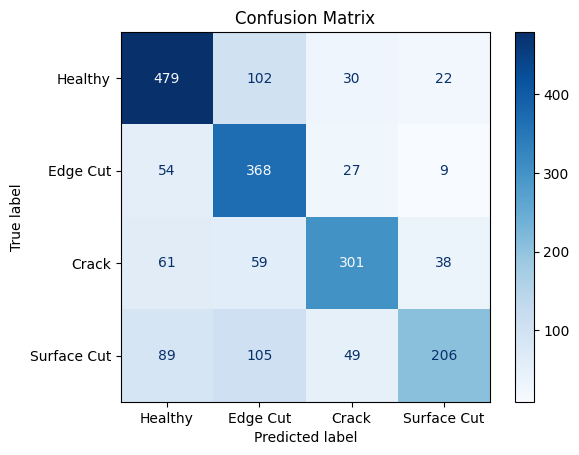

In [ ]:
# Predict probabilities for test set
y_pred_proba = model.predict(X_test_padded)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_proba, axis=1)

# True labels as class indices (if one-hot encoded)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy','Edge Cut','Crack','Surface Cut'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {i}: Precision={p:.3f}, Recall={r:.3f}, F1-score={f:.3f}")

# Or print full classification report
print(classification_report(y_true, y_pred,target_names = class_names))


Class 0: Precision=0.701, Recall=0.757, F1-score=0.728
Class 1: Precision=0.580, Recall=0.803, F1-score=0.674
Class 2: Precision=0.740, Recall=0.656, F1-score=0.695
Class 3: Precision=0.749, Recall=0.459, F1-score=0.569
              precision    recall  f1-score   support

     Healthy       0.70      0.76      0.73       633
    Edge Cut       0.58      0.80      0.67       458
       Crack       0.74      0.66      0.70       459
 Surface Cut       0.75      0.46      0.57       449

    accuracy                           0.68      1999
   macro avg       0.69      0.67      0.67      1999
weighted avg       0.69      0.68      0.67      1999

